In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
!pip install ipyplot pip install pytorch_lightning==1.6.0

In [ ]:
import pandas as pd
import ipyplot
import torch
import pytorch_lightning as pl
from sklearn.metrics import f1_score
%matplotlib inline


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [ ]:
!pip install timm

In [ ]:
from model import ImageClassifier
from utils import ImagesDataset, evaluate_model
from transforms import transform
import params

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip drive/MyDrive/dataset_students

# Load dataset

In [ ]:
test_df = pd.read_csv('dataset/classification/train_labelled.csv')
test_df.head()

,img_path,label
0,dataset/classification/train_labelled/0.png,0
1,dataset/classification/train_labelled/1.png,0
2,dataset/classification/train_labelled/2.png,0
3,dataset/classification/train_labelled/3.png,0
4,dataset/classification/train_labelled/4.png,0


In [ ]:
test_image_paths = test_df.img_path.values
test_labels = test_df.label.values

In [ ]:
len(test_image_paths)

1000

In [ ]:
ipyplot.plot_class_tabs(train_image_paths, train_labels)

# Prepare model

In [ ]:
test_dataset = ImagesDataset(test_image_paths, test_labels, transform=transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=params.BATCH_SIZE,
                                           num_workers=16,
                                           shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Run macos_cert_fix.py if you are getting ssl errors
model = ImageClassifier(learning_rate=params.LEARNING_RATE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [ ]:
!mkdir dataset
!mv dataset_students/classification/ dataset

In [ ]:
trainer = pl.Trainer(
    max_epochs=params.MAX_EPOCHS,
    log_every_n_steps=-1, # Change to enable tensorboard logging
    #gpus=-1, # Uncomment to use GPU training
)
trainer.fit(model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/trainer.py:1823: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 2.2 M 
----

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/trainer.py:727: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Compute training set accuracy

In [ ]:
labels, predictions = evaluate_model(model, train_dataset)

100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


In [ ]:
f1_score(labels, predictions, labels=1, average='binary')

0.14939309056956118

# Save model

In [ ]:
trainer.save_checkpoint("model.ckpt")

In [ ]:
!pip install toloka-kit
!pip install crowd-kit

In [ ]:
import toloka.client as toloka
import toloka.client.project.template_builder as tb
from crowdkit.aggregation import MajorityVote, DawidSkene
import datetime
import time
import requests
import json
import numpy as np
import pandas as pd
import os

In [ ]:
tasks_token='y0_AgAAAAB08TDMAAmX9gAAAAEDTvm4AACwbCIMdlVJdb16RO1gr7-Ve0x0TQ'
toloka_client = toloka.TolokaClient(tasks_token, url = 'https://tasks.yandex.ru')

In [ ]:
!curl -X GET 'https://tasks.yandex.ru/api/v1/requester' \
     -H "Authorization: OAuth y0_AgAAAAB08TDMAAmX9gAAAAEDTvm4AACwbCIMdlVJdb16RO1gr7-Ve0x0TQ"

{"id":"7e99eee543347cc64265301f6dbf74ad","balance":799.1005,"public_name":{"EN":"ШАД-69"},"company":{"id":"151","superintendent_id":"64ef54a8b2a44461537f06b121533c42"}}

In [ ]:
answers_df = toloka_client.get_assignments_df(2051719)
answers_df = answers_df.rename(columns={
    'INPUT:image_url': 'task',
    'OUTPUT:result': 'label',
    'ASSIGNMENT:worker_id': 'worker',
})[['task', 'label', 'worker']]

In [ ]:
from crowdkit.aggregation import MajorityVote
mv = MajorityVote()
mv_result = mv.fit_predict(data=answers_df)
mv_labels = pd.DataFrame({'url':mv_result.index, 'result': mv_result.values})

In [ ]:
mv_labels

,url,result
0,"""https://i.ibb.co/0297dGw/5161.png""",other
1,"""https://i.ibb.co/029G3Pg/6949.png""",other
2,"""https://i.ibb.co/02HwC2z/7972.png""",other
3,"""https://i.ibb.co/02LQqMt/4323.png""",other
4,"""https://i.ibb.co/02LXvx9/6285.png""",other
...,...,...
9242,"""https://i.ibb.co/zszFx1V/6522.png""",other
9243,"""https://i.ibb.co/zszb091/6593.png""",other
9244,"""https://i.ibb.co/zx7Lt3R/3093.png""",other
9245,"""https://i.ibb.co/zxg9Hzx/1837.png""",other


In [ ]:
control = pd.read_csv('/content/main_pool_number.tsv', sep='\t')
control_urls = set(control['INPUT:image_url'])

In [ ]:
url_label = {url[1:-1]: result for url, result in zip(mv_labels['url'],mv_labels['result'])}

In [ ]:
url_label_unlabeled = {url: label for url,label in url_label.items() if url not in control_urls}

In [ ]:
len(url_label_unlabeled)

8435

In [ ]:
url_label_unlabeled

In [ ]:
def get_number_from_url(s):
  index = s.find('/', s.find('/', s.find('/', s.find('/') + 1) + 1) + 1)
  return s[index+1: s.find('.png')]

number_label = {get_number_from_url(url): label for url, label in url_label_unlabeled.items()}

In [ ]:
def get_path_from_number(s):
  return f'dataset/classification/train_unlabelled/{s}.png'

path_label = {get_path_from_number(url): label for url, label in number_label.items()}

In [ ]:
path_label

In [ ]:
 p = []
 l = []
 for i,j in path_label.items():
  p.append(i)
  if j == 'other':
    j = 0
  if j == 'russian':
    j = 1
  l.append(j)

d = {'img_path': p, 'label': l}

In [ ]:
data = pd.DataFrame.from_dict(d)
data

,img_path,label
0,dataset/classification/train_unlabelled/5161.png,0
1,dataset/classification/train_unlabelled/6949.png,0
2,dataset/classification/train_unlabelled/7972.png,0
3,dataset/classification/train_unlabelled/4323.png,0
4,dataset/classification/train_unlabelled/6285.png,0
...,...,...
8430,dataset/classification/train_unlabelled/6522.png,0
8431,dataset/classification/train_unlabelled/6593.png,0
8432,dataset/classification/train_unlabelled/3093.png,0
8433,dataset/classification/train_unlabelled/1837.png,0


In [ ]:
train_image_paths = data.img_path.values
train_labels = data.label.values

In [ ]:
ipyplot.plot_class_tabs(train_image_paths, train_labels)

In [ ]:
train_dataset = ImagesDataset(train_image_paths, train_labels, transform=transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=params.BATCH_SIZE,
                                           num_workers=16,
                                           shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Run macos_cert_fix.py if you are getting ssl errors
model = ImageClassifier(learning_rate=params.LEARNING_RATE)

In [ ]:
trainer = pl.Trainer(
    max_epochs=params.MAX_EPOCHS,
    log_every_n_steps=-1, # Change to enable tensorboard logging
    gpus=-1, # Uncomment to use GPU training
)
trainer.fit(model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 2.2 M 
---------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.906     Total estimated model

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
labels, predictions = evaluate_model(model.cpu(), test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799ddb388ee0>
Traceback (most recent call last):
Exception ignored in: Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProce

  0%|          | 0/32 [00:01<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score

In [ ]:
sum(labels)/len(labels)

0.08

In [ ]:
f1_score(labels, predictions, labels=1, average='binary')

0.7692307692307693

In [ ]:
accuracy_score(labels, predictions)

0.961

In [ ]:
recall_score(labels, predictions), precision_score(labels, predictions)

(0.8125, 0.7303370786516854)

In [ ]:
recall_score(1 - np.array(labels), 1 - np.array(predictions)), precision_score(1 - np.array(labels), 1 - np.array(predictions))

(0.9739130434782609, 0.9835345773874863)

In [ ]:
balanced_accuracy_score(labels, predictions)

0.8932065217391305

In [ ]:
print(len(test_dataset))

8435


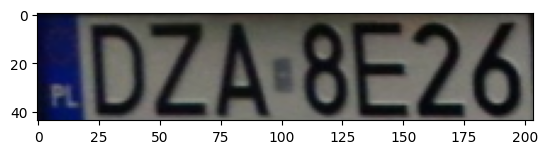

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('dataset/classification/train_unlabelled/6949.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
train_labels

array(['other', 'other', 'other', ..., 'other', 'other', 'other'],
      dtype=object)

In [ ]:
!unrar x drive/MyDrive/test

In [ ]:
import os
# assign directory
directory = 'test'

test = []
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        test.append(f)

In [ ]:
final_test = pd.DataFrame.from_dict({'img_path': test, 'label': [0 for i in range(len(test))]})

In [ ]:
final_test

,img_path,label
0,test/4919.png,0
1,test/5540.png,0
2,test/5113.png,0
3,test/4115.png,0
4,test/127.png,0
...,...,...
5869,test/387.png,0
5870,test/1933.png,0
5871,test/5822.png,0
5872,test/3642.png,0


In [ ]:
final_test_paths = final_test.img_path.values
final_test_labels = final_test.label.values

In [ ]:
final_test_dataset = ImagesDataset(final_test_paths, final_test_labels, transform=transform)

In [ ]:
labels, predictions = evaluate_model(model.cpu(), final_test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/184 [00:00<?, ?it/s]

In [ ]:
final_test_list = [i for i in final_test_paths]

In [ ]:
output = pd.DataFrame.from_dict({'img_path': final_test_list, 'label': predictions})

In [ ]:
def to_int(s):
  return int(s[s.find('/') + 1:s.find('.png')])

In [ ]:
output['img_path'] = output['img_path'].apply(to_int)

In [ ]:
output = output.sort_values(by=['img_path'])

In [ ]:
def process(s):
  return 'dataset/classification/val/' + str(s) + '.png'

In [ ]:
output['img_path'] = output['img_path'].apply(process)

In [ ]:
output

,img_path,label
1062,dataset/classification/val/0.png,0
1858,dataset/classification/val/1.png,0
2582,dataset/classification/val/2.png,0
1981,dataset/classification/val/3.png,0
5422,dataset/classification/val/4.png,0
...,...,...
5652,dataset/classification/val/5869.png,0
5250,dataset/classification/val/5870.png,0
4041,dataset/classification/val/5871.png,1
3903,dataset/classification/val/5872.png,0


In [ ]:
output.to_csv(r'output.csv', header='img_path,label', index=None, sep=',', mode='a')

In [ ]:
sum(list(output['label']))/len(list(output['label']))

0.08733401430030643